In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import keras 

df = pd.read_pickle('dataset/train_dataset.pkl')


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

In [248]:

def get_train_test_dataset(df):
    split_date = '2015-12-28 10:29:13'
    data_train = df.loc[df['Timestamp'] <= split_date].copy()
    data_test = df.loc[df['Timestamp'] > split_date].copy()

    return data_train, data_test

In [3]:
training, test = get_train_test_dataset()
test = test.reset_index(drop=True)

cols_numeric = list(df.columns)

cols_numeric.remove('index')
cols_numeric.remove('attack')


#Transform to numeric data to be able to do the SC
# training['Timestamp'] = pd.to_numeric(training['Timestamp'])
training['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)

# test['Timestamp'] = pd.to_numeric(test['Timestamp'])
test['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)

# We only fit on the trainset to avoid data leakage from the testset
# data_num = training[cols_numeric]
# train_set = (data_num-data_num.min())/(data_num.max()-data_num.min())

# test_num = test[cols_numeric]
# test_set = (test_num-test_num.min())/(test_num.max()-test_num.min())


In [18]:
cols_continuous_tank = ['LIT101', 'LIT301', 'LIT401']

HH=1000
H=800
L=500 
LL=250

def get_level_tank(tank):
    if tank <= LL:
        return 1
    elif tank > LL and tank <= L:
        return 2
    elif tank > L and tank <= H:
        return 3
    elif tank > H and tank <= HH:
        return 4
    elif tank > HH:
        return 5
        

# create discrete variables for the tank levels
for col in cols_continuous_tank:
    df[f'{col}_discrete'] = df[col].apply(get_level_tank)
    

In [44]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

for col in cols_continuous_tank:
    cols_numeric.remove(col)

cols_discrete = []
cols_continous = []

for col in cols_numeric:
    
    if len(df[col].unique()) <= 5:
        cols_discrete.append(col)
    else:
        cols_continous.append(col)

In [ ]:

def get_state(row, quantiles):
    if row <= quantiles[0.25]:
        return 1
    elif row > quantiles[0.25] and row <= quantiles[0.5]:
        return 2
    elif row > quantiles[0.5] and row <= quantiles[0.75]:
        return 3
    elif row > quantiles[0.75]:
        return 4
        
        
# create discrete variables for the continuous variables
for col in cols_continous:
    quantiles = df[col].quantile([0.25, 0.5, 0.75])
    df[f'{col}_discrete'] = df[col].apply(lambda x: get_state(x, quantiles))


In [83]:
for col in cols_discrete:
    df[f'{col}_discrete'] = df[col]

In [ ]:
df['Normal/Attack_discrete'] = df['Normal/Attack_discrete'].apply(lambda x: 0 if x == 'Normal' else 1)

In [ ]:
for col in df.columns:
    if 'discrete' in col:
        print(col)
        print(df[col].value_counts())
        print('------------------------')

In [100]:
# df_copy.to_pickle('dataset/train_dataset_discrete.pkl')

In [106]:
df_discrete = pd.read_pickle('dataset/train_dataset_discrete.pkl')

In [107]:
discrete_cols = []
for col in df_discrete.columns:
    if 'discrete' in col:
        discrete_cols.append(col)

In [ ]:
# data = df_discrete.iloc[0:10000]

# data_time = [i for i in range(len(data))]


# fig = plt.figure(figsize=(16, 9), dpi=300)
# ax = plt.axes(projection ='3d')
# ax.view_init(0 + 20, -90 + 30)
# ax.scatter(data['LIT101_discrete'], data['FIT101_discrete'], data_time, c='green', s=1, alpha=0.8)
# # ax.scatter(data['LIT101'], data['FIT101'], data_time, c='orange', s=1, alpha=0.8)
# plt.show()

## Analysing total number of State in the dataset

In [249]:
train, test = get_train_test_dataset(data)

Number of total existing state in the df dataset

In [253]:
len(df_discrete[discrete_cols].value_counts())

308520

Number of total existing state in the training dataset

In [251]:
len(train[discrete_cols].value_counts())

155970

# KMeans clustering

In [265]:
df_discrete['Normal/Attack_discrete'] = df_discrete['Normal/Attack_discrete'].apply(lambda x: 0 if x == 'Normal' else 1)
df['Normal/Attack_discrete']

In [283]:
df['Normal/Attack_discrete'].value_counts()

Normal    878419
Attack     53900
Name: Normal/Attack_discrete, dtype: int64

In [269]:
discrete_cols = []
for col in df_discrete.columns:
    if 'discrete' in col:
        discrete_cols.append(col)

In [272]:
dataset = df_discrete[discrete_cols].copy()
y = dataset['Normal/Attack_discrete']

cols_keep = df_discrete[discrete_cols].columns.tolist()
cols_keep.remove('Normal/Attack_discrete')
data = dataset[cols_keep]

k = 100

In [273]:

kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
label = kmeans.labels_
centroid = kmeans.cluster_centers_

data['Timestamp'] = df_discrete['Timestamp']
data['Normal/Attack_discrete'] = y
data['label'] = label

In [274]:
data

,LIT101_discrete,LIT301_discrete,LIT401_discrete,FIT101_discrete,FIT201_discrete,FIT301_discrete,FIT401_discrete,FIT501_discrete,FIT502_discrete,FIT503_discrete,FIT504_discrete,FIT601_discrete,AIT201_discrete,AIT202_discrete,AIT203_discrete,DPIT301_discrete,AIT401_discrete,AIT402_discrete,AIT501_discrete,AIT502_discrete,AIT503_discrete,AIT504_discrete,PIT501_discrete,PIT502_discrete,PIT503_discrete,MV101_discrete,P101_discrete,P102_discrete,MV201_discrete,P201_discrete,P203_discrete,P204_discrete,P205_discrete,P206_discrete,MV301_discrete,MV302_discrete,MV303_discrete,MV304_discrete,P301_discrete,P302_discrete,P402_discrete,P403_discrete,UV401_discrete,P501_discrete,P602_discrete,Timestamp,Normal/Attack_discrete,label
0,3,4,4,2,4,1,1,1,2,3,3,4,3,2,4,1,1,4,3,4,3,2,4,4,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,2015-12-22 20:00:00,1,59
1,3,4,4,2,4,1,1,1,3,3,3,4,3,2,4,1,1,4,3,4,3,2,4,4,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,2015-12-22 20:00:01,1,59
2,3,4,4,2,4,1,1,1,3,3,3,4,3,2,4,1,1,4,3,4,3,2,4,4,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,2015-12-22 20:00:02,1,59
3,3,4,4,2,4,1,1,1,4,3,4,4,3,2,4,1,1,4,3,4,3,2,4,4,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,2015-12-22 20:00:03,1,59
4,3,4,4,2,4,1,1,1,4,3,4,4,3,2,4,1,1,4,3,4,3,2,4,4,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,2015-12-22 20:00:04,1,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932314,3,4,4,3,4,1,2,2,3,2,1,1,1,4,1,4,1,1,1,1,1,4,3,1,2,2,2,1,2,2,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2016-01-02 14:59:55,1,75
932315,3,4,4,3,4,1,2,2,2,2,1,1,1,4,1,4,1,1,1,1,1,4,3,1,2,2,2,1,2,2,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2016-01-02 14:59:56,1,75
932316,3,4,4,3,4,1,2,2,2,2,1,1,1,4,1,4,1,1,1,1,1,4,3,1,2,2,2,1,2,2,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2016-01-02 14:59:57,1,75
932317,3,4,4,3,4,1,2,2,1,2,3,1,1,4,1,4,1,1,1,1,1,4,3,1,2,2,2,1,2,2,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2016-01-02 14:59:58,1,75


In [276]:

def get_time_dataset(df, time_1, time_2):
    data = df[df['Timestamp'].between(time_1, time_2)]
    data['Timestamp'] = df['Timestamp']
    return data

In [284]:
data['Normal/Attack_discrete'] = df['Normal/Attack_discrete']
data['Normal/Attack_discrete'] = data['Normal/Attack_discrete'].apply(lambda x: 0 if x == 'Normal' else 1)


In [285]:
# get the first attack
data_p = get_time_dataset(data, '2015-12-28 10:29:13', '2015-12-28 15:20:13')

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_11780/389973463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = df['Timestamp']


In [278]:
data_p

,LIT101_discrete,LIT301_discrete,LIT401_discrete,FIT101_discrete,FIT201_discrete,FIT301_discrete,FIT401_discrete,FIT501_discrete,FIT502_discrete,FIT503_discrete,FIT504_discrete,FIT601_discrete,AIT201_discrete,AIT202_discrete,AIT203_discrete,DPIT301_discrete,AIT401_discrete,AIT402_discrete,AIT501_discrete,AIT502_discrete,AIT503_discrete,AIT504_discrete,PIT501_discrete,PIT502_discrete,PIT503_discrete,MV101_discrete,P101_discrete,P102_discrete,MV201_discrete,P201_discrete,P203_discrete,P204_discrete,P205_discrete,P206_discrete,MV301_discrete,MV302_discrete,MV303_discrete,MV304_discrete,P301_discrete,P302_discrete,P402_discrete,P403_discrete,UV401_discrete,P501_discrete,P602_discrete,Timestamp,Normal/Attack_discrete,label
484153,4,4,4,2,1,3,2,3,3,3,3,4,3,3,2,2,3,2,3,2,2,2,2,4,2,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 10:29:13,1,9
484154,4,4,4,3,1,3,2,3,2,3,3,4,3,3,2,2,3,2,3,2,2,2,2,4,2,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 10:29:14,1,9
484155,4,4,4,3,1,3,2,3,2,3,3,4,3,3,2,2,3,2,3,2,2,2,2,4,2,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 10:29:15,1,9
484156,4,4,4,3,1,3,2,3,2,3,3,4,3,3,2,2,3,2,3,2,2,2,2,4,2,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 10:29:16,1,9
484157,4,4,4,3,1,3,2,3,3,3,3,4,3,3,2,2,3,2,3,2,2,2,2,4,2,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 10:29:17,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501609,3,4,4,2,2,3,4,4,4,1,1,4,3,2,2,2,3,2,3,2,3,3,1,4,1,2,2,1,2,1,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 15:20:09,1,7
501610,3,4,4,2,2,3,4,4,4,1,1,4,3,2,2,2,3,2,3,2,3,3,1,4,1,2,2,1,2,1,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 15:20:10,1,7
501611,3,4,4,2,2,3,4,4,4,1,1,4,3,2,2,2,3,2,3,2,3,3,1,4,1,2,2,1,2,1,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 15:20:11,1,7
501612,3,4,4,3,2,4,4,4,4,1,1,4,3,2,2,2,3,2,3,2,3,3,1,4,1,2,2,1,2,1,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,2015-12-28 15:20:12,1,7


In [286]:
data_p[['label', 'Normal/Attack_discrete']].value_counts(dropna=False)

label  Normal/Attack_discrete
7      0                         4430
89     0                         1982
57     0                         1952
36     0                         1501
65     0                         1346
57     1                         1155
53     0                          752
7      1                          671
3      1                          566
65     1                          564
68     1                          454
53     1                          412
9      0                          326
68     0                          320
36     1                          252
39     0                          250
       1                          198
9      1                          116
2      0                           54
32     0                           45
1      1                           36
58     1                           16
81     1                           15
71     0                           12
44     0                           11
32     1            

## Creation of sequence

In [258]:
TIME_WINDOW = 30


In [275]:

all_sequence = pd.DataFrame()

sequence = data_p.iloc[0:TIME_WINDOW]['label'].tolist()
for i in range(len(data_p)-TIME_WINDOW-1):
    sequence = sequence[1:]
    sequence.append(data_p.iloc[i+TIME_WINDOW+1]['label'])
    all_sequence = all_sequence.append({'sequence':sequence}, ignore_index=True)
    

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_11780/2776553931.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sequence = all_sequence.append({'sequence':sequence}, ignore_index=True)
/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_11780/2776553931.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sequence = all_sequence.append({'sequence':sequence}, ignore_index=True)
/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_11780/2776553931.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sequence = all_sequence.append({'sequence':sequence}, ignore_index=True)
/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_11780/2776553931.py:7: FutureWarning: The frame.append meth

KeyboardInterrupt: 

In [235]:
all_sequence['sequence_str'] = all_sequence['sequence'].apply(lambda x: str(x))

In [236]:
cols_l = ['attack', 'sequence_str']
all_sequence[cols_l].value_counts()

attack  sequence_str                                                                              
0       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]    7321
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]    2113
1       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]    1561
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]     604
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]     437
                                                                                                      ... 
0       [5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]       1
        [5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3]       1
        [5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 

In [239]:
len(all_sequence['sequence_str'].unique())

3989

# Create Model

## PCA Analysis

In [35]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

df['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)


X_norm = (df[cols_numeric] - df[cols_numeric].min())/(df[cols_numeric].max() - df[cols_numeric].min())
X_norm = X_norm.fillna(0)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pca = PCA(n_components=3) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))

transformed['Attack/Normal'] = df['Normal/Attack']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


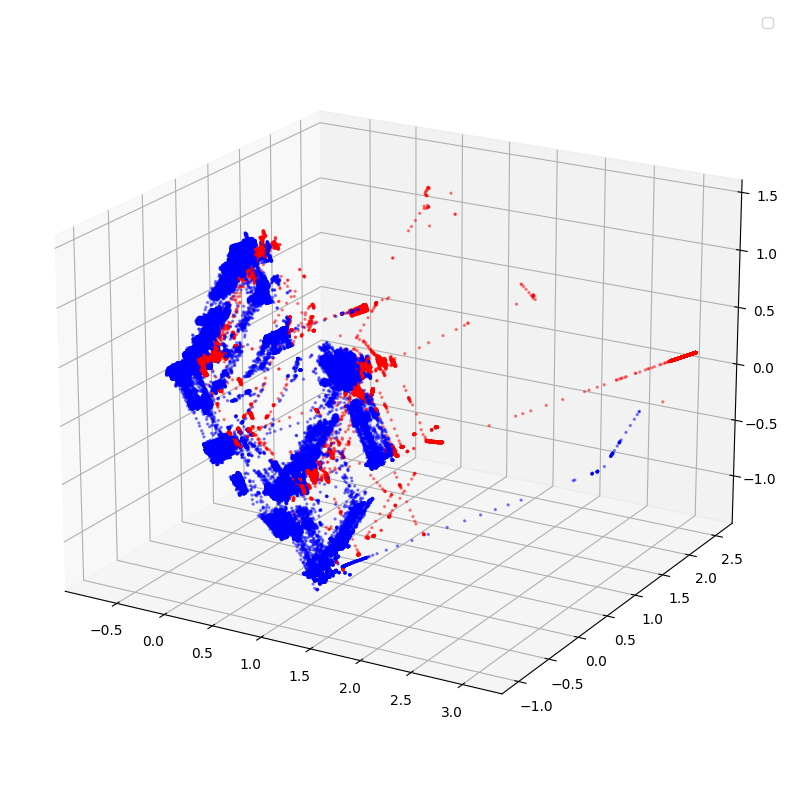

In [42]:
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.view_init(30, 30)
color_ = ['red' if l == 1 else 'blue' for l in transformed['Attack/Normal']]

ax.scatter(transformed[0], transformed[1], transformed[2], c=color_, s=2, alpha=0.4)


# sns.scatterplot(x=transformed[0], y=transformed[1], hue=transformed['Attack/Normal'], palette=['green', 'red'], alpha=0.5, s=5, linewidth=0, legend='full')
plt.legend()
plt.show()

In [ ]:
%%time
from sklearn import datasets
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# fit a k-nearest neighbor model to the data
model = KNeighborsClassifier()
model.fit(X_train, y_train)
print(model)
# make predictions
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))